# Scikit-downscale: an open source Python package for scalable climate downscaling

Joseph Hamman (jhamman@ucar.edu) and Julia Kent (jkent@ucar.edu)

NCAR, Boulder, CO, USA

-------

This notebook was developed for the [2020 EarthCube All Hands Meeting](https://www.earthcube.org/EC2020). The development of Scikit-downscale done in conjunction with the development of the [Pangeo Project](http://pangeo.io/) and was supported by the following awards:

- [NSF-GEO-AGS 1928374: EarthCube Data Capabilities: Collaborative Proposal: Jupyter meets the Earth: Enabling discovery in geoscience through interactive computing at scale](https://www.nsf.gov/awardsearch/showAward?AWD_ID=1740633)
- [NSF-OIA 1937136: Convergence Accelerator Phase I (RAISE): Knowledge Open Network Queries for Research (KONQUER)](https://www.nsf.gov/awardsearch/showAward?AWD_ID=1937136)

ECAHM 2020 ID: 143

-------

## 1. Introduction

Climate data from Earth System Models (ESMs) are increasingly being used to study the impacts of climate change on a broad range of biogeophysical systems (forest fire, flood, fisheries, etc.) and human systems (water resources, power grids, etc.). Before this data can be used to study many of these systems, post-processing steps commonly referred to as bias correction and statistical downscaling must be performed. “Bias correction” is used to correct persistent biases in climate model output and “statistical downscaling” is used to increase the spatiotemporal resolution of the model output (i.e. from 1 deg to 1/16th deg grid boxes). For our purposes, we’ll refer to both parts as “downscaling”.

In the past few decades, the applications community has developed a plethora of downscaling methods. Many of these methods are ad-hoc collections of processing routines while others target very specific applications. The proliferation of downscaling methods has left the climate applications community with an overwhelming body of research to sort through without much in the form of synthesis guilding method selection or applicability.

Motivated by the pressing socio-environmental challenges of climate change – and with the learnings from previous downscaling efforts (e.g. Gutmann et al. 2014, Lanzante et al. 2018) in mind – we have begun working on a community-centered open framework for climate downscaling: [scikit-downscale](https://scikit-downscale.readthedocs.io/en/latest/). We believe that the community will benefit from the presence of a well-designed open source downscaling toolbox with standard interfaces alongside a repository of benchmark data to test and evaluate new and existing downscaling methods.

In this notebook, we provide an overview of the scikit-downscale project, detailing how it can be used to downscale a range of surface climate variables such as surface air temperature and precipitation. We also highlight how scikit-downscale framework is being used to compare exisiting methods and how it can be extended to support the development of new downscaling methods.

## 2. Scikit-downscale
Scikit-downscale is a new open source Python project. Within Scikit-downscale, we are been curating a collection of new and existing downscaling methods within a common framework. Key features of Scikit-downscale are:

- A high-level interface modeled after the popular `fit` / `predict` pattern found in many machine learning packages ([Scikit-learn](https://scikit-learn.org/stable/index.html), [Tensorflow](https://www.tensorflow.org/guide/keras), etc.),
- Uses [Xarray](http://xarray.pydata.org/en/stable/) and [Pandas](https://pandas.pydata.org/) data structures and utilities for handling of labeled datasets,
- Utilities for automatic parallelization of pointwisde downscaling models,
- Common interface for pointwise and spatial (or global) downscaling models, and
- Extensible, allowing the creation of new downscaling methods through composition.

Scikit-downscale's source code is available on [GitHub](https://github.com/jhamman/scikit-downscale).

### 2.1 Pointwise Models
We define pointwise methods as those that only use local information during the downscaling process. They can be often represented as a general linear model and fit independently across each point in the study domain. Examples of existing pointwise methods are:

- BCSD_[Temperature, Precipitation]: Wood et al. (2004)
- ARRM: Stoner et al. (2012)
- (Hybrid) Delta Method (e.g. Hamlet et al. (2010)
- [GARD](https://github.com/NCAR/GARD): Gutmann et al (in prep). 

Because pointwise methods can be written as a stand-alone linear model, Scikit-downscale implements these models as a Scikit-learn [LinearModel](https://scikit-learn.org/stable/modules/linear_model.html) or [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). By building directly on Scikit-learn, we inherit a well defined model API and the ability to interoperate with a robust ecosystem utilities for model evaluation and optimization (e.g. grid-search). Perhaps more importantly, this structure also allows us to compare methods at a high-level of granularity (single spatial point) before deploying them on large domain problems.

-------

***Begin interactive demo***

-------

From here forward in this notebook, we'll jump back and forth between Python and text cells to describe how scikit-downscale works.

This first cell just imports some libraries and get's things setup for our analysis to come.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from utils import get_sample_data

sns.set(style='darkgrid')

Now that we've imported a few libraries, let's open a sample dataset from a single point in North America. We'll use this data to explore Scikit-downscale and its existing functionality. You'll notice there are two groups of data, `training` and `targets`. The `training` data is meant to represent data from a typical climate model and the `targets` data is meant to represent our "observations". For the purpose of this demonstration, we've choosen training data sampled from a regional climate model (WRF) run at 50km resolution over North America. The observations are sampled from the nearest 1/16th grid cell in Livneh et al, 2013.

We have choosen to use the `tmax` variable (daily maximum surface air temperature) for demonstration purposes. With a small amount of effort, an interested reader could swap `tmax` for `pcp` and test these methods on precipitation.

training               targets          
                 tmax           pcp    tmax       pcp
time                                                 
1950-01-01        NaN           NaN   -0.22  5.608394
1950-01-02        NaN           NaN   -4.54  2.919726
1950-01-03        NaN           NaN   -7.87  3.066762
1950-01-04        NaN           NaN   -5.08  4.684164
1950-01-05        NaN           NaN   -0.79  4.295568
...               ...           ...     ...       ...
2015-11-26   7.657013  0.000000e+00     NaN       NaN
2015-11-27   7.687256  0.000000e+00     NaN       NaN
2015-11-28  10.480835  0.000000e+00     NaN       NaN
2015-11-29  11.728516  0.000000e+00     NaN       NaN
2015-11-30  10.285431  3.152419e-13     NaN       NaN

[24075 rows x 4 columns]

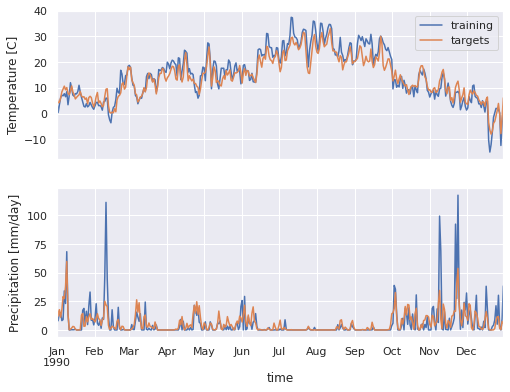

In [2]:
# load sample data
training = get_sample_data('training')
targets = get_sample_data('targets')

# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))

# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['tmax'].plot(ax=axes[0], label='training')
targets[time_slice]['tmax'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Temperature [C]')

# plot-precipitation
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')

### 2.2 Models as cattle, not pets

As we mentioned above, Scikit-downscale utilizes a similiar API to that of Scikit-learn for its pointwise models. This means we can build collections of models that may be quite different internally, but operate the same at the API level. Importantly, this means that all downscaling methods have two common API methods: `fit`, which trains the model given _training_ and _targets_ data, and `predict` which uses the fit model to perform the downscaling opperation. This is perhaps the most important feature of Scikit-downscale, the ability to test and compare arbitrary combinations of models under a common interface. This allows us to try many combinations of models and parameters, choosing only the best combinations. The following pseudo-code block describe the workflow common to all scikit-downscale models:

```python
from skdownscale.pointwise_models import MyModel

...
# load and pre-process input data (X and y)
...

model = MyModel(**parameters)
model.fit(X_train, y)
predictions = model.predict(X_predict)

...
# evaluate and/or save predictions
...


```

In the cell below, we'll create nine different downscaling models, some from Scikit-downscale and some from Scikit-learn.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')


Now that we've created a collection of models, we want to train the models on the same input data. We do this by looping through our dictionary of models and calling the `fit` method:

In [4]:
# extract training / prediction data
X_train = training[['tmax']][train_slice]
y_train = targets[['tmax']][train_slice]
X_predict = training[['tmax']][predict_slice]

# Fit all models
for key, model in models.items():
    model.fit(X_train, y_train)

Just like that, we fit nine downscaling models. Now we want to use those models to downscale/bias-correct our data. For the sake of easy comparison, we'll use a different part of the training data:

In [5]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    predict_df[key] = model.predict(X_predict)

# show a table of the predicted data
display(predict_df.head())

,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,BCSD: BcsdTemperature,Sklearn: RandomForestRegressor
time,,,,,,,,,
1990-01-01,4.50,5.67,5.375299,5.697786,5.895,5.931445,5.781472,4.528703,5.2024
1990-01-02,6.13,3.55,3.543398,3.264698,2.561,2.515919,2.524322,-1.584749,4.6935
1990-01-03,5.46,3.04,4.963575,4.933534,4.692,4.862730,4.944167,2.848937,4.6736
1990-01-04,8.57,5.90,8.369125,8.239455,7.340,7.255379,7.107427,6.687826,8.4134
1990-01-05,5.67,7.03,7.424970,7.583703,7.705,7.711861,7.878299,8.296425,6.5789


Now, let's do some sample analysis on our predicted data. First, we'll look at a timeseries of all the downscaled timeseries for the first year of the prediction period. In the figure below, the `target` (truth) data is shown in black, the original (pre-correction) data is shown in grey, and each of the downscaled data timeseries is shown in a different color.

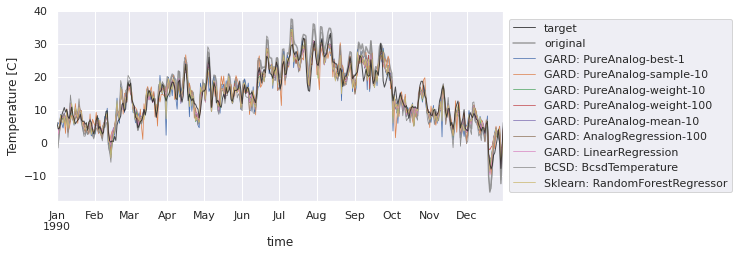

In [6]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['tmax'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['tmax'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]')

Of course, its difficult to tell which of the nine downscaling methods performed best from our plot above. We may want to evaluate our predictions using a standard statistical score, such as $r^2$. Those results are easily computed below:

In [7]:
# calculate r2
score = (predict_df.corrwith(targets.tmax[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
GARD: PureAnalog-best-1,0.820281
GARD: PureAnalog-sample-10,0.820977
BCSD: BcsdTemperature,0.858258
Sklearn: RandomForestRegressor,0.864160
GARD: PureAnalog-weight-10,0.881287
GARD: PureAnalog-weight-100,0.892049
GARD: PureAnalog-mean-10,0.899297
GARD: AnalogRegression-100,0.906217
GARD: LinearRegression,0.906316


All of our downscaling methods seem to be doing fairly well. The timeseries and statistics above shows that all our methods are producing generally resonable results. However, we are often interested in how our models do at predicting extreme events. We can quickly look into those aspects of our results using the `qq` plots below. There you'll see that the models diverge in some interesting ways. For example, while the `LinearRegression` method has the highest $r^2$ score, it seems to have trouble capturing extreme heat events. Whereas many of the analog methods, as well as the `RandomForestRegressor`, perform much better on the tails of the distributions.

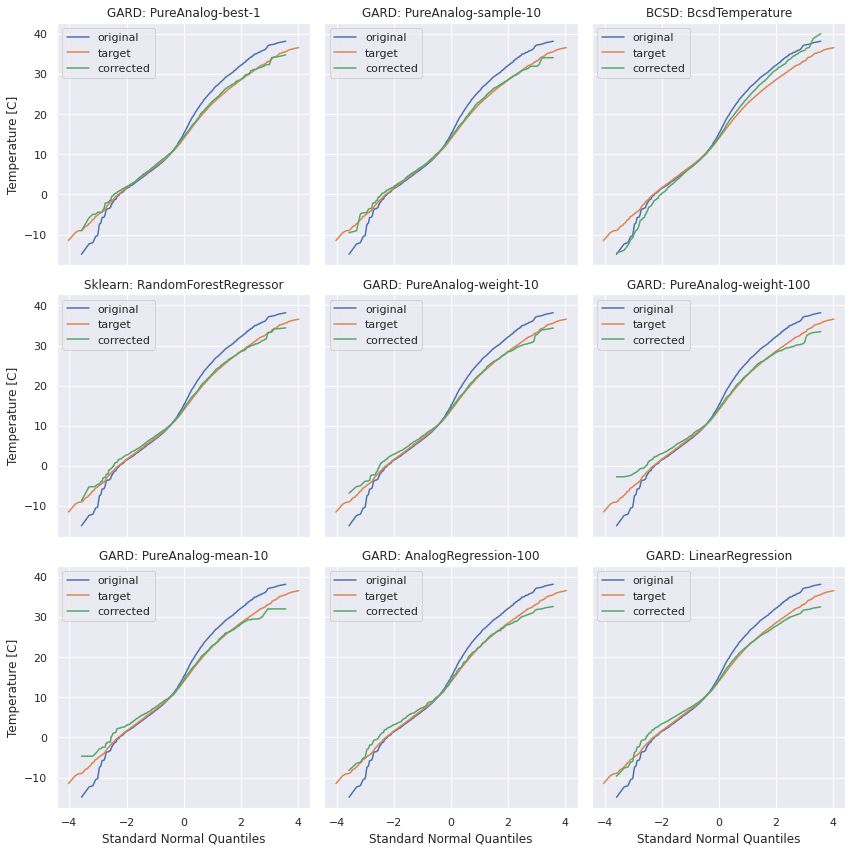

In [8]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['tmax'], predict_df[score.index.values], shape=(3, 3), figsize=(12, 12))

In this section, we've shown how easy it is to fit, predict, and evaluate scikit-downscale models. The seamless interoperability of these models clearly facilitates a workflow that enables a deeper level of model evaluation that is otherwise possible in the downscaling world. 

### 2.3 Tailor-made methods in a common framework

In the section above, we showed how it is possible to use scikit-downscale to bias-correct a timeseries of daily maximum air temperature using an arbitrary collection of linear models. Some of those models were general machine learning methods (e.g. `LinearRegression` or `RandomForestRegressor`) while others were tailor-made methods developed specifically for downscaling (e.g. `BCSDTemperature`). In this section, we walk through how new pointwise methods can be added to the scikit-downscale framework, highlighting the Z-Score method along the way.

#### 2.3.1 Z-Score Method

Z-Score bias correction is a good technique for target variables with Gaussian probability distributions, such as zonal wind speed.

In essence the technique:

1. Finds the mean  
$$\overline{x} = \sum_{i=0}^N \frac{x_i}{N}$$ 
and standard deviation 
$$\sigma = \sqrt{\frac{\sum_{i=0}^N |x_i - \overline{x}|^2}{N-1}}$$ 
of target (measured) data and training (historical modeled) data. 

2. Compares the difference between the statistical values to produce a shift 
$$shift = \overline{x_{target}} - \overline{x_{training}}$$ 
and scale parameter 
$$scale = \sigma_{target} \div \sigma_{training}$$ 

3. Applies these paramaters to the future model data to be corrected to get a new mean
$$\overline{x_{corrected}} = \overline{x_{future}} + shift$$
and new standard deviation
$$\sigma_{corrected} = \sigma_{future} \times scale$$

4. Calculates the corrected values
$$x_{corrected_{i}} = z_i \times \sigma_{corrected} + \overline{x_{corrected}}$$
from the future model's z-score values
$$z_i = \frac{x_i-\overline{x}}{\sigma}$$

In practice, if the wind was on average 3 m/s faster on the first of July in the models compared to the measurements, we would adjust the modeled data for all July 1sts in the future modeled dataset to be 3 m/s faster. And similarly for scaling the standard deviation

#### 2.3.2 Building the ZScoreRegressor Class

Scikit-downscale's pointwise all implement Scikit-learn's `fit`/`predict` API. Each new downscaler must implement a minimum of three class methods: `__init__`, `fit`, `predict`. 

```python
class AbstractDownscaler(object):
    
    def __init__(self):
        ...
    
    def fit(self, X, y):
        ...
        return self
    
    def predict(X):
        ...
        return y_hat
```

Ommitting some of the complexity in the full implementation (which can be found in the [full implementation on GitHub](https://github.com/jhamman/scikit-downscale/blob/master/skdownscale/pointwise_models/zscore.py)), we demonstrate how the `ZScoreRegressor` was built:

First, we define our `__init__` method, allowing users to specify specific options (in this case `window_width`):
```python
class ZScoreRegressor(object):
    
    def __init__(self, window_width=31):
        self.window_width = window_width
```

Next, we define our `fit` method, 

```python
    def fit(self, X, y):
        X_mean, X_std = _calc_stats(X.squeeze(), self.window_width)
        y_mean, y_std = _calc_stats(y.squeeze(), self.window_width)
        
        self.stats_dict_ = {
            "X_mean": X_mean,
            "X_std": X_std,
            "y_mean": y_mean,
            "y_std": y_std,
        }

        shift, scale = _get_params(X_mean, X_std, y_mean, y_std)

        self.shift_ = shift
        self.scale_ = scale
        return self
```

Finally, we define our `predict` method,

```python
    def predict(self, X):

        fut_mean, fut_std, fut_zscore = _get_fut_stats(X.squeeze(), self.window_width)
        shift_expanded, scale_expanded = _expand_params(X.squeeze(), self.shift_, self.scale_)

        fut_mean_corrected, fut_std_corrected = _correct_fut_stats(
            fut_mean, fut_std, shift_expanded, scale_expanded
        )

        self.fut_stats_dict_ = {
            "meani": fut_mean,
            "stdi": fut_std,
            "meanf": fut_mean_corrected,
            "stdf": fut_std_corrected,
        }

        fut_corrected = (fut_zscore * fut_std_corrected) + fut_mean_corrected

        return fut_corrected.to_frame(name)
```

In [9]:
from skdownscale.pointwise_models import ZScoreRegressor

In [10]:
# open a small dataset
training = get_sample_data('wind-hist')
target = get_sample_data('wind-obs')
future = get_sample_data('wind-rcp')

In [11]:
# bias correction using ZScoreRegresssor
zscore = ZScoreRegressor()
zscore.fit(training, target)
fit_stats = zscore.fit_stats_dict_
out = zscore.predict(future)
predict_stats = zscore.predict_stats_dict_

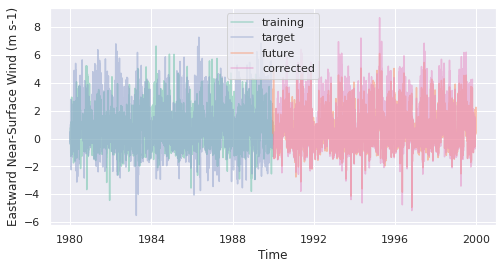

In [12]:
# visualize the datasets
from utils import zscore_ds_plot

zscore_ds_plot(training, target, future, out)

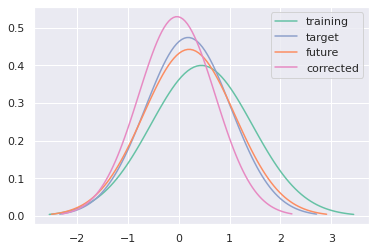

In [13]:
from utils import zscore_correction_plot

zscore_correction_plot(zscore)

### 2.4 Automatic Parallelization

In the examples above, we have performed downscaling on sample data sourced from individual points. In many downscaling workflows, however, users will want to apply pointwise methods at all points in their study domain. For this use case, scikit-downscale provides a high-level wrapper class: `PointWiseDownscaler`.

In the example below, we'll use the `BCSDTemperature` model, along with the `PointWiseDownscaler` wrapper, to downscale daily maximum surface air temperature from CMIP6 for all point in a subset of the Pacific Norwest. We'll use a local [Dask Cluster](https://dask.org/) to distribute the computation among our available processors. Though not the point of this example, we also use [intake-esm](https://intake-esm.readthedocs.io/en/latest/) to access [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) data stored on [Google Cloud Storage](https://console.cloud.google.com/marketplace/details/noaa-public/cmip6).

**Data:**
  - Training / Prediction data: NASA-GISS-E2 historical data from CMIP6
  - Targets: [GridMet](http://www.climatologylab.org/gridmet.html) daily maximum surface air temperature

In [14]:
# parameters
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(-124.8, -120.0) 
lat_slice = slice(50, 45)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

Step 1: Start a Dask Cluster. Xarray and the `PointWiseDownscaler` will make use of this cluster when it comes time to load input data and train/predict downscaling models. 

In [15]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:41711 Dashboard: /user/jhamman/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


Step 2. Load our target data. 

Here we use xarray directly to load a collection of OpenDAP endpoints. 

In [16]:
import xarray as xr

fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='pydap', concat_dim='day').rename({'day': 'time'}).drop('crs')

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(obs_subset)
obs_subset.isel(time=0).plot()

<xarray.DataArray 'air_temperature' (time: 1096, lat: 106, lon: 115)>
dask.array<xarray-<this-array>, shape=(1096, 106, 115), dtype=float32, chunksize=(1096, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-31
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 45.15 45.11 45.07 45.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -120.1 -120.1 -120.0

Step 3: Load our training/prediction data.

Here we use `intake-esm` to access a single Xarray dataset from the Pangeo's Google Cloud CMIP6 data catalog. 

'2020.6.11'

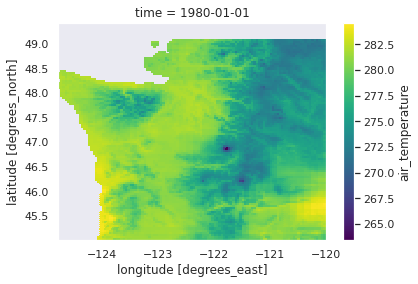

In [17]:
import intake_esm
intake_esm.__version__

<xarray.DataArray 'tasmax' (time: 1096, lat: 106, lon: 115)>
dask.array<xarray-<this-array>, shape=(1096, 106, 115), dtype=float32, chunksize=(1096, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-31
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 45.15 45.11 45.07 45.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -120.1 -120.1 -120.0

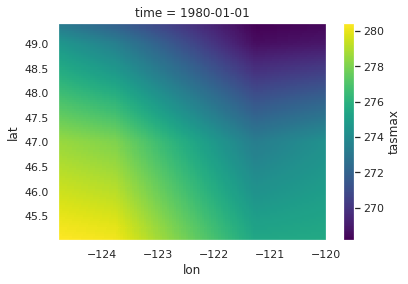

In [18]:
import intake

# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
                 grid_label='gn')

# access the data and do some cleanup
ds_model = cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

# regional subsets, ready for downscaling
train_subset = ds_model['tasmax'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

holdout_subset = ds_model['tasmax'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(train_subset)
train_subset.isel(time=0).plot()

Step 4. Now that we have loaded our training and target data, we can move on to fit our BcsdTemperature model at each x/y point in our domain. This is where the `PointWiseDownscaler` comes in:

In [19]:
from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
model

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    BcsdTemperature(return_anoms=False)

Step 5. We fit the `PointWiseDownscaler`, passing it data in Xarray data structures (our regional subsets from above). This opperation is lazy and return immediately. Under the hood, we can see that `PointWiseDownscaler._models` is an `Xarray.DataArray` of `BcsdTemperature` models.

<div class="alert-warning">
Note: The following two cells may take a few minutes, or longer, to complete depending on how many cores your computer has, and your internet connection.     
</div>

In [20]:
model.fit(train_subset, obs_subset)
display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    BcsdTemperature(return_anoms=False)

<xarray.DataArray 'tasmax' (lat: 106, lon: 115)>
dask.array<_fit_wrapper-723171662d2ffd5ed708bc9f7d1b3a95-<this, shape=(106, 115), dtype=object, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 45.15 45.11 45.07 45.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -120.1 -120.1 -120.0

Step 6. Finally, we can use our model to complete the downscaling workflow using the `predict` method along with our `holdout_subset` of CMIP6 data. We call the `.load()` method to eagerly compute the data. We end by plotting a map of downscaled data over our study area.

<xarray.DataArray (time: 730, lat: 106, lon: 115)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 272.9068 , 272.03818,
         271.74667],
        [      nan,       nan,       nan, ..., 272.58118, 271.9899 ,
         271.59863],
        [      nan,       nan,       nan, ..., 272.38995, 271.89896,
         271.48502]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 272.2721 , 271.3799 ,
         271.10745],
        [      nan,       nan,       nan, ..., 271.8796 , 271.28778,
         270.87622],
        [      nan,       nan,       nan, ..., 271.8478 , 271.35623,
         270.78433]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 270.06155, 269.17004,
         268.7786 ],
        [      nan,       nan,       nan, ..., 269.6548 , 269.1635 ,
         268.67227],
        [      nan,       nan,       nan, ..., 269.63492, 269.057  ,
         268.65283]],

       ...,

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 277.1879 , 276.33917,
         276.03476],
        [      nan,       nan,       nan, ..., 276.86758, 276.36328,
         275.859  ],
        [      nan,       nan,       nan, ..., 276.79156, 276.2874 ,
         275.82758]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 277.70404, 277.39084,
         276.97433],
        [      nan,       nan,       nan, ..., 277.34024, 276.8421 ,
         276.762  ],
        [      nan,       nan,       nan, ..., 277.26825, 276.48682,
         276.36444]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 281.16882, 280.37064,
         280.07254],
        [      nan,       nan,       nan, ..., 280.88696, 280.38916,
         279.8914 ],
        [      nan,       nan,       nan, ..., 280.80515, 280.2077 ,
         279.81027]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 45.15 45.11 45.07 45.03
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1991-12-31
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -120.1 -120.1 -120.0

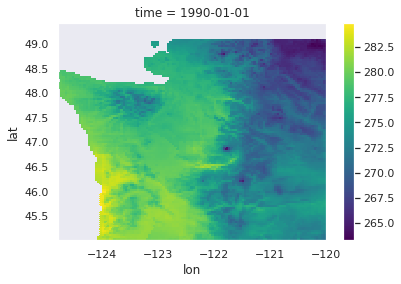

In [21]:
predicted = model.predict(holdout_subset).load()
display(predicted)
predicted.isel(time=0).plot()

### 2.2 Spatial Models
Spatial models is a second class of downscaling methods that use information from the full study domain to form relationships between observations and ESM data. Scikit-downscale implements these models as as SpatialDownscaler. Beyond providing fit and predict methods that accept Xarray objects, the internal layout of these methods is intentionally unspecified. We are currently working on wrapping a few popular spatial downscaling models such as:

- [MACA: Multivariate Adaptive Constructed Analogs](http://www.climatologylab.org/maca.html), Abatzoglou and Brown (2012)
- [LOCA: Localized Constructed Analogs](http://loca.ucsd.edu/), Pierce, Cayan, and Thrasher (2014)

## 3. Discussion

### 3.1 Benchmark Applications
Its likely that one of the reasons we haven’t seen strong consensus develop around particularl downscaling methodologies is the abscense of widely available benchamrk applications to test methods against eachother. While Scikit-downscale will not solve this problem on its own, we hope the ability to implemnt downscaling applications within a common framework will enable a more robust benchmarking inititive that previously possible.

### 3.2 Call for Participation
The Scikit-downscale effort is just getting started. With the recent release of [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6), we expect a surge of interest in downscaled climate data. There are clear opportunities for involvement from climate impacts practicioneers, computer scientists with an interest in machine learning for climate applications, and climate scientists alike. Please reach out if you are interested in participating in any way.

## References

1. Abatzoglou, J. T. (2013), Development of gridded surface meteorological data for ecological applications and modelling. Int. J. Climatol., 33: 121–131.
1. Abatzoglou J.T. and Brown T.J. A comparison of statistical downscaling methods suited for wildfire applications, International Journal of Climatology (2012), 32, 772-780
1. Gutmann, E., Pruitt, T., Clark, M. P., Brekke, L., Arnold, J. R., Raff, D. A., and Rasmussen, R. M. ( 2014), An intercomparison of statistical downscaling methods used for water resource assessments in the United States, Water Resour. Res., 50, 7167– 7186, doi:10.1002/2014WR015559.
1. Gutmann, E., J. Hamman, M. Clark, T. Eidhammer, A. Wood, J. Arnold, K. Nowak (in prep), Evaluating the effect of statistical downscaling methodological choices in a common framework. To be submitted to JGR-Atomspheres.
1. Hamlet, A.F., Salathé, E.P., and Carrasco, P., 2010. Statistical downscaling techniques for global climate model simulations of temperature and precipitation with application to water resources planning studies. A report prepared by the Climate Impact Group for Columbia Basin Climate Change Scenario Project, University of Washington, Seattle, WA.
http://www.hydro.washington.edu/2860/products/sites/r7climate/study_report/CBCCSP_chap4_gcm_draft_20100111.pdf
1. Lanzante JR, KW Dixon, MJ Nath, CE Whitlock, and D Adams-Smith (2018): Some Pitfalls in Statistical Downscaling of Future Climate. Bulletin of the American Meteorological Society. DOI: 0.1175/BAMS-D-17-0046.1.
1. Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392.
1. Pierce, D. W., D. R. Cayan, and B. L. Thrasher, 2014: Statistical downscaling using Localized Constructed Analogs (LOCA). Journal of Hydrometeorology, volume 15, page 2558-2585
1. Stoner, A., K. Hayhoe, and X. Yang (2012), An asynchronous regional regression model for statistical downscaling of daily climate variables, Int. J. Climatol., 33, 2473–2494, doi:10.1002/joc.3603.
1. Wood, A., L. Leung, V. Sridhar, and D. Lettenmaier (2004), Hydrologic implications of dynamical and statistical approaches to downscaling climate model outputs, Clim. Change, 62, 189–216.

## License

This notebook is licensed under [CC-BY](https://creativecommons.org/licenses/by/4.0/). Scikit-downscale is licensed under [Apache License 2.0](https://github.com/jhamman/scikit-downscale/blob/master/LICENSE).